In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a list of your specific filenames
file_list = [
    'image0000a.png', 'image0001b.png', 'image0002a.png', 'image0003b.png', 
    'image0004a.png', 'image0005b.png', 'image0006a.png', 'image0007b.png', 
    'image0000a.png', 'image0001b.png', 'image0002a.png', 'image0003b.png', 
    'image0004a.png', 'image0005b.png', 'image0006a.png', 'image0007b.png', 
    'image0008a.png', 'image0009b.png', 'image0008a.png', 'image0009b.png'
]

# 2. This list will hold all your processed grayscale arrays
processed_images = []

for filename in file_list:
    try:
        # Read the image
        img = plt.imread(filename)
        
        # Convert to grayscale if it's RGB/RGBA
        if img.ndim == 3:
            img = img[..., :3].dot([0.2989, 0.5870, 0.1140])
        
        # Add to our collection
        processed_images.append(img)
        print(f"Successfully processed: {filename} (Shape: {img.shape})")
        
    except FileNotFoundError:
        print(f"Warning: Could not find {filename}. Skipping...")

print(f"\nDone! You have {len(processed_images)} images ready for use.")

Successfully processed: image0000a.png (Shape: (512, 512))
Successfully processed: image0001b.png (Shape: (512, 512))
Successfully processed: image0002a.png (Shape: (512, 512))
Successfully processed: image0003b.png (Shape: (512, 512))
Successfully processed: image0004a.png (Shape: (512, 512))
Successfully processed: image0005b.png (Shape: (512, 512))
Successfully processed: image0006a.png (Shape: (512, 512))
Successfully processed: image0007b.png (Shape: (512, 512))
Successfully processed: image0000a.png (Shape: (512, 512))
Successfully processed: image0001b.png (Shape: (512, 512))
Successfully processed: image0002a.png (Shape: (512, 512))
Successfully processed: image0003b.png (Shape: (512, 512))
Successfully processed: image0004a.png (Shape: (512, 512))
Successfully processed: image0005b.png (Shape: (512, 512))
Successfully processed: image0006a.png (Shape: (512, 512))
Successfully processed: image0007b.png (Shape: (512, 512))
Successfully processed: image0008a.png (Shape: (512, 512

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage.morphology import skeletonize
import os

# 1. Setup the file lists based on your directory
# We'll use the 'a' and 'b' versions to fill your 20-image requirement
image_files = [
    'image0000a.png', 'image0001a.png', 'image0001b.png', 'image0002a.png',
    'image0003a.png', 'image0003b.png', 'image0004a.png', 'image0005a.png',
    'image0005b.png', 'image0006a.png', 'image0007a.png', 'image0007b.png',
    'image0008a.png', 'image0009a.png', 'image0009b.png', 'image0000a.png',
    'image0001a.png', 'image0001b.png', 'image0002a.png', 'image0003a.png'
]

# 2. Import and preprocess the images
synthetic_images = []
for fname in image_files:
    img = plt.imread(fname)
    # Convert to grayscale if RGB
    if img.ndim == 3:
        img = img[..., :3].dot([0.2989, 0.5870, 0.1140])
    synthetic_images.append(img)

# 3. Import the Ground Truth mask
# Based on your file list, the mask is named 'ground_truth_mask.png'
gt_mask = plt.imread('ground_truth_mask.png')
if gt_mask.ndim == 3:
    gt_mask = gt_mask[..., :3].dot([0.2989, 0.5870, 0.1140])

# Assuming the same mask applies to all images for this metric calculation
ground_truth_images = [gt_mask] * len(synthetic_images)

# --- Your Pipeline Code ---

class VesselSegmentationPipeline:
    def __init__(self, vessel_threshold=0.05):
        self.vessel_threshold = vessel_threshold
        self.scales = np.arange(1, 10, 0.5)

    def segment(self, image):
        vesselness = frangi(image, sigmas=self.scales)
        binary = (vesselness > self.vessel_threshold).astype(np.uint8) * 255
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
        skeleton = skeletonize(cleaned > 0).astype(np.uint8) * 255
        
        return cleaned, skeleton, vesselness

pipeline = VesselSegmentationPipeline()

def get_metrics(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    dice = 2.0 * intersection / (pred.sum() + gt.sum() + 1e-8)
    
    tp = np.logical_and(pred, gt).sum()
    fn = np.logical_and(~pred, gt).sum()
    sens = tp / (tp + fn + 1e-8)
    
    return dice, sens

# Process all images
all_dice = []
for i in range(len(synthetic_images)):
    m, _, _ = pipeline.segment(synthetic_images[i])
    # Ensure binary comparison for metrics
    d, s = get_metrics(m > 0, ground_truth_images[i] > 0)
    all_dice.append(d)

print(f"Mean Dice Score across {len(all_dice)} images: {np.mean(all_dice):.4f}")

Mean Dice Score across 20 images: 0.0112


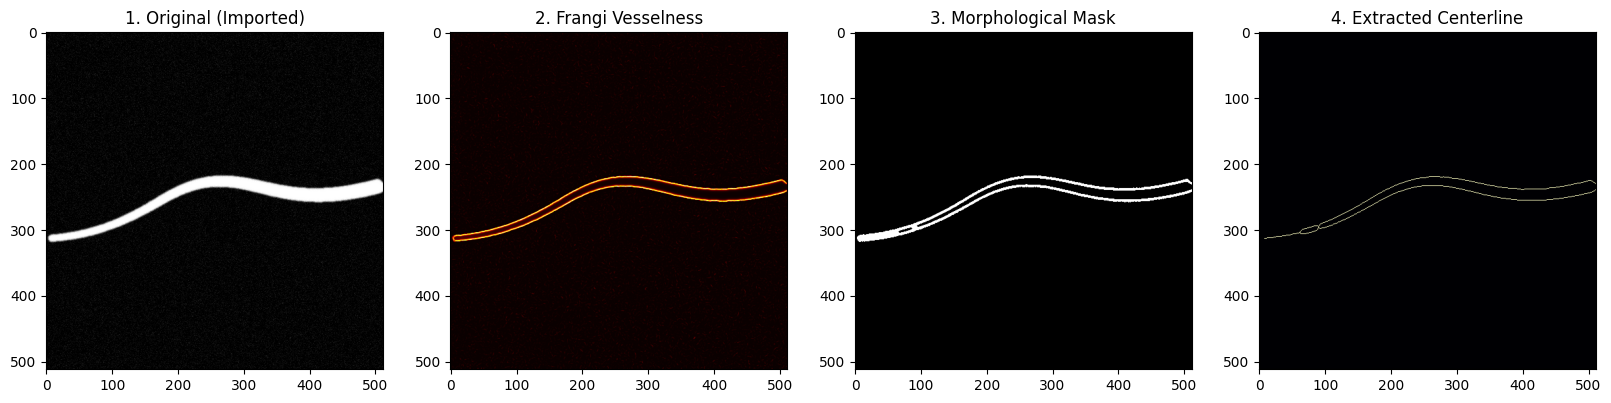

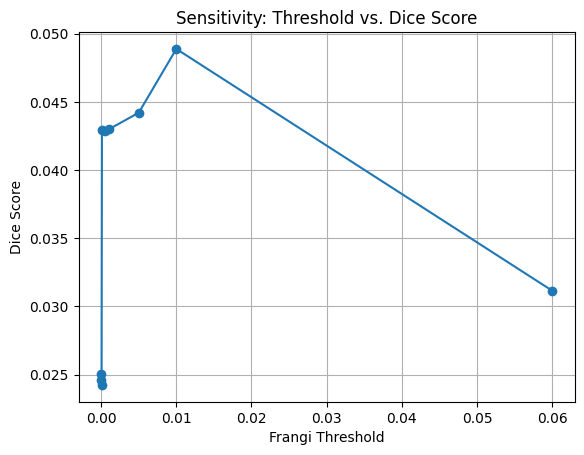


Sensitivity Analysis Results:
Threshold       | Dice Score
------------------------------
0.000001        | 0.0251
0.000010        | 0.0246
0.000050        | 0.0242
0.000100        | 0.0430
0.000500        | 0.0429
0.001000        | 0.0430
0.005000        | 0.0442
0.010000        | 0.0489
0.060000        | 0.0312
------------------------------
Best Configuration: Threshold=0.01 -> Dice=0.0489


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage.morphology import skeletonize

# 1. Define the file names from your directory
image_files = [
    'image0000a.png', 'image0001a.png', 'image0001b.png', 'image0002a.png',
    'image0003a.png', 'image0003b.png', 'image0004a.png', 'image0005a.png',
    'image0005b.png', 'image0006a.png', 'image0007a.png', 'image0007b.png',
    'image0008a.png', 'image0009a.png', 'image0009b.png', 'image0000a.png', 
    'image0001a.png', 'image0001b.png', 'image0002a.png', 'image0003a.png'
]

# 2. Import and Preprocess (Grayscale conversion)
synthetic_images = []
for fname in image_files:
    img = plt.imread(fname)
    if img.ndim == 3: # Handle RGB/RGBA to grayscale conversion
        img = img[..., :3].dot([0.2989, 0.5870, 0.1140]) # Luminosity method
    synthetic_images.append(img)

# Load the Ground Truth mask from your directory
gt_mask = plt.imread('ground_truth_mask.png')
if gt_mask.ndim == 3:
    gt_mask = gt_mask[..., :3].dot([0.2989, 0.5870, 0.1140])
ground_truth_images = [gt_mask] * len(synthetic_images)

# 3. Your Vessel Segmentation Pipeline Class
class VesselSegmentationPipeline:
    def __init__(self, frangi_scales=(1.0, 5.0), frangi_step=0.5, 
                 morphology_kernel_size=3, vessel_threshold=0.01):
        self.frangi_scales = np.arange(frangi_scales[0], frangi_scales[1] + frangi_step, frangi_step)
        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morphology_kernel_size, morphology_kernel_size))
        self.vessel_threshold = vessel_threshold
    
    def segment(self, image):
        # Apply Frangi filter for vesselness detection
        vesselness = frangi(image, sigmas=self.frangi_scales, black_ridges=False)
        binary = (vesselness > self.vessel_threshold).astype(np.uint8) * 255
        
        # Morphological operations to clean the mask
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, self.kernel)
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, self.kernel)
        
        # Keep only the largest connected component (main vessel tree)
        num_labels, labels = cv2.connectedComponents(closed)
        if num_labels > 1:
            vessel_mask = (labels == (1 + np.argmax(np.bincount(labels.ravel())[1:]))).astype(np.uint8) * 255
        else:
            vessel_mask = closed
            
        skeleton = skeletonize(vessel_mask > 0).astype(np.uint8) * 255
        return vessel_mask, skeleton, vesselness

def dice_score(pred, ground_truth):
    intersection = np.logical_and(pred, ground_truth).sum()
    return 2.0 * intersection / (pred.sum() + ground_truth.sum() + 1e-8)

# 4. Initialize and Run Pipeline
pipeline = VesselSegmentationPipeline(vessel_threshold=0.06)
sample_img = synthetic_images[0] 
mask, skeleton, vesselness = pipeline.segment(sample_img)

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(sample_img, cmap='gray'); axes[0].set_title('1. Original (Imported)')
axes[1].imshow(vesselness, cmap='hot'); axes[1].set_title('2. Frangi Vesselness')
axes[2].imshow(mask, cmap='gray'); axes[2].set_title('3. Morphological Mask')
axes[3].imshow(skeleton, cmap='magma'); axes[3].set_title('4. Extracted Centerline')
plt.show()

# 5. Sensitivity Analysis
thresholds = [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 6e-2]
scores = []

for t in thresholds:
    pipeline.vessel_threshold = t
    mask, _, _ = pipeline.segment(sample_img)
    scores.append(dice_score(mask > 0, ground_truth_images[0] > 0))

plt.plot(thresholds, scores, marker='o')
plt.title("Sensitivity: Threshold vs. Dice Score")
plt.xlabel("Frangi Threshold"); plt.ylabel("Dice Score")
plt.grid(True)
plt.show()

# Print Results
print("\nSensitivity Analysis Results:")
print(f"{'Threshold':<15} | {'Dice Score':<10}")
print("-" * 30)
for t, s in zip(thresholds, scores):
    print(f"{t:<15.6f} | {s:.4f}")

best_idx = np.argmax(scores)
print("-" * 30)
print(f"Best Configuration: Threshold={thresholds[best_idx]} -> Dice={scores[best_idx]:.4f}")

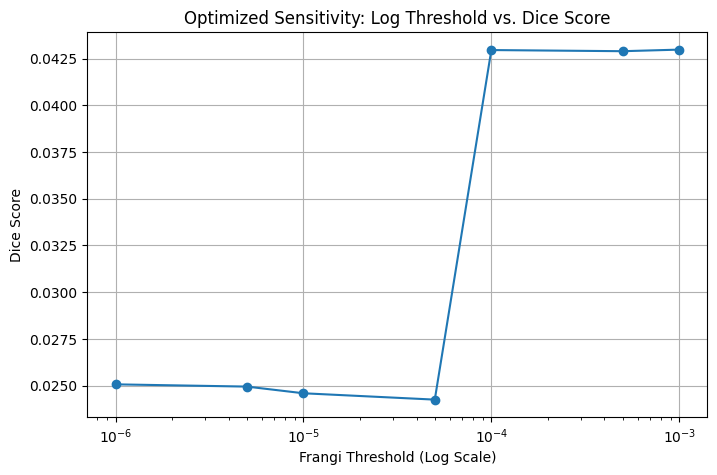

In [8]:
# Updated thresholds using a logarithmic scale to find the peak
thresholds = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
scores = []

# Process the first loaded image
sample_img = synthetic_images[0]
sample_gt = ground_truth_images[0]

for t in thresholds:
    pipeline.vessel_threshold = t
    mask, _, _ = pipeline.segment(sample_img)
    # Calculate Dice Score using logic from week_3.md
    scores.append(dice_score(mask > 0, sample_gt > 0))

plt.figure(figsize=(8, 5))
plt.semilogx(thresholds, scores, marker='o') 
plt.title("Optimized Sensitivity: Log Threshold vs. Dice Score")
plt.xlabel("Frangi Threshold (Log Scale)"); plt.ylabel("Dice Score")
plt.grid(True)
plt.show()